# title

list all video ids from youtube: https://github.com/yt-dlp/yt-dlp#general-options
command: `python yt-dlp --print "%(id)s" "<link do canal>" > <nome do arquivo de saida>.txt`
reference: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [24]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Or BertTokenizer
#from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
#from transformers import AutoModel  # or BertModel, for BERT without pretraining heads


from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /home/maximalist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
import os
path_accent = next(os.walk('data'))[1]

In [26]:
accent_list = []

for index, path in enumerate(path_accent):
    onlyfiles = [f for f in listdir(f'data/{path}') if isfile(join(f'data/{path}', f))]
    
    for file in onlyfiles:
        transcription_df = pd.DataFrame(pd.read_json(f'data/{path}/{file}'))
        transcription = ' '.join(transcription_df['text'])
        accent_list.append({"transcription":transcription, "target": path})

In [27]:
accent_df = pd.json_normalize(accent_list)

In [28]:
accent_df

,transcription,target
0,e eu vou te falar um negócio eu gostei no cabe...,mineiro
1,a galera do meu canal aqui estou hoje baile do...,mineiro
2,eu não posso ficar aqui muito sem muito não cu...,mineiro
3,e ai agora ela acha que é foto eu achei que é ...,mineiro
4,O que é o que não pode falar Ah entendi isso q...,mineiro
...,...,...
1127,é meu caraca uec mais um branquinho demanda é ...,fluminense
1128,oi tudo bem boa tarde tá olhando você de longe...,fluminense
1129,para uma calorosa paixão não existe preconceit...,fluminense
1130,aqui ó a pista de 10 tu tava correndo a 15 tu ...,fluminense


In [29]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append('[música]')
stopwords.append('[Música]')
stopwords.append('[aplausos]')
stopwords.append('[Aplausos]')
stopwords.append('[ __ ]')
stopwords.append('aqui')
stopwords.append('aí')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maximalist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def remove_stop_words(sentence):  
  words = sentence.lower().split() 
  
  filtered_words = [word for word in words if word not in stopwords] 
   
  return ' '.join(filtered_words)
accent_df['transcription'] = accent_df['transcription'].map(remove_stop_words)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(accent_df['transcription'], accent_df['target'], test_size=0.33, random_state=42)

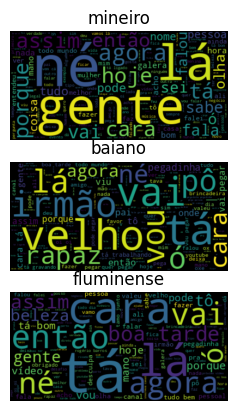

In [32]:
number_plots = len(accent_df['target'].unique())

wc = WordCloud()

for index, accent in enumerate(accent_df['target'].unique()):
    accent_desc = ', '.join(accent_df[accent_df['target'] == accent]['transcription'])
    
    wc.generate(text=accent_desc)   
    plt.subplot(number_plots, 1, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(accent)
    
plt.show()

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(758, 24467)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(758, 24467)

# using nb classifier

In [35]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])

text_clf = text_clf.fit(X_train, y_train)

In [36]:
predicted = text_clf.predict(X_test)
print(np.mean(predicted == y_test))

0.6978609625668449


# Using SVM

In [37]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,random_state=42))])

_ = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print(np.mean(predicted_svm == y_test))

0.946524064171123


In [38]:
accent_df['target'].unique()

array(['mineiro', 'baiano', 'fluminense'], dtype=object)

              precision    recall  f1-score   support

     mineiro       1.00      0.81      0.90        54
      baiano       0.91      0.90      0.91        59
  fluminense       0.94      0.98      0.96       261

    accuracy                           0.95       374
   macro avg       0.95      0.90      0.92       374
weighted avg       0.95      0.95      0.95       374


Text(0.5, 1.0, 'class')

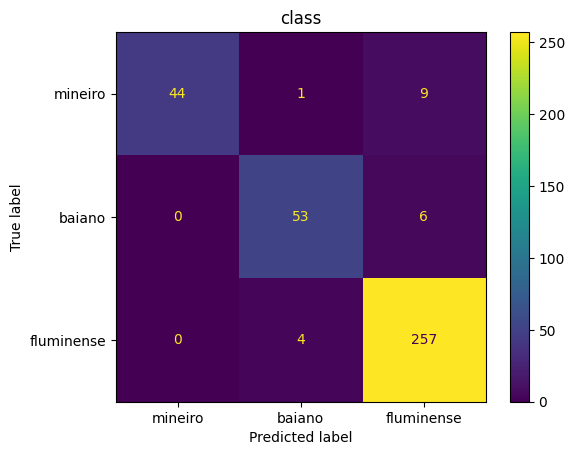

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, predicted_svm, target_names=accent_df['target'].unique()))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_svm),
                              display_labels=accent_df['target'].unique())
disp.plot()
disp.ax_.set_title(f'class')


# using bert - n deu certo ainda :(

In [40]:
#model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
#tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)

In [41]:
#import torch

#model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')

#tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)
#input_ids = tokenizer.encode('Tinha uma pedra no meio do caminho.', return_tensors='pt')

#with torch.no_grad():
#    outs = model(input_ids)
#    encoded = outs[0][0, 1:-1]
#print(encoded.shape)
#print(outs)

In [42]:
#model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-large-portuguese-cased")